In [124]:
!pip install geopy
!pip install geopandas

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopy
import geopandas as gpd
# pd.set_option('display.max_colwidth', -1)

from google.colab import drive
drive.mount('/content/drive')

patterns_paths = [
                  '/content/drive/My Drive/SafeGraph data/march_safegraph_updated.csv',
                  '/content/drive/My Drive/SafeGraph data/april_safegraph_updated.csv',
                  '/content/drive/My Drive/SafeGraph data/may_safegraph_updated.csv',
                  '/content/drive/My Drive/SafeGraph data/june_safegraph_updated.csv',
                  '/content/drive/My Drive/SafeGraph data/july_safegraph_updated.csv',
                  '/content/drive/My Drive/SafeGraph data/august_safegraph_updated.csv',
                  '/content/drive/My Drive/SafeGraph data/september_safegraph_updated.csv'
                 ]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [126]:
monthly_patterns_raw = pd.read_csv(patterns_paths[0])

In [127]:
monthly_patterns_raw.head()

,safegraph_place_id,location_name,street_address,city,region,postal_code,safegraph_brand_ids,brands,date_range_start,date_range_end,raw_visit_counts,raw_visitor_counts,visits_by_day,poi_cbg,visitor_home_cbgs,visitor_daytime_cbgs,visitor_work_cbgs,visitor_country_of_origin,distance_from_home,median_dwell,bucketed_dwell_times,related_same_day_brand,related_same_month_brand,popularity_by_hour,popularity_by_day,device_type,placekey,Latitude,Longitude
0,sg:01d30e9d0c0d45dba33a963a443b41eb,Flako and Victor Auto Diagnostic Repair,10875 San Fernando Rd Ste 5,Pacoima,CA,91331,NaN,NaN,2020-03-01T00:00:00-08:00,2020-04-01T00:00:00-07:00,5,4,"[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",6037104404,{},"{""060371341012"":4}",{},{},NaN,6.0,"{""<5"":0,""5-20"":3,""21-60"":0,""61-240"":2,"">240"":0}","{""Food 4 Less"":100}","{""Smart & Final"":75,""ARCO"":74,""Domino's Pizza""...","[0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,3,0,0,1,1,0,0,0,0]","{""Monday"":1,""Tuesday"":0,""Wednesday"":0,""Thursda...","{""android"":0,""ios"":0}",NaN,34.267799,-118.423950
1,sg:02e7de2c19284c6a930ade85565ae8bc,Baked,6027 Reseda Blvd,Tarzana,CA,91356,NaN,NaN,2020-03-01T00:00:00-08:00,2020-04-01T00:00:00-07:00,75,33,"[0, 6, 4, 5, 4, 3, 3, 1, 5, 2, 4, 1, 3, 0, 1, ...",6037139302,"{""060371393021"":4,""060371394012"":4,""0603712710...","{""060371393021"":6,""060371112063"":4,""0603713130...","{""060371393021"":4}","{""US"":28}",8705.0,19.0,"{""<5"":3,""5-20"":35,""21-60"":3,""61-240"":9,"">240"":25}","{""Vons"":33,""Restaurant Depot"":25}","{""Starbucks"":32,""McDonald's"":31,""Costco Wholes...","[0,1,1,1,1,1,3,4,11,14,26,31,32,34,31,25,14,3,...","{""Monday"":17,""Tuesday"":15,""Wednesday"":12,""Thur...","{""android"":17,""ios"":19}",NaN,34.179249,-118.536051
2,sg:18d6ea1dc7444521a0d67c23af363d92,Men's Center of L A,21243 Ventura Blvd Ste 214,Woodland Hills,CA,91364,NaN,NaN,2020-03-01T00:00:00-08:00,2020-04-01T00:00:00-07:00,1,1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6037137502,{},{},{},{},NaN,31.0,"{""<5"":0,""5-20"":0,""21-60"":1,""61-240"":0,"">240"":0}","{""Jack in the Box"":100}","{""Fry's Electronics"":100,""Ralphs"":100,""99 Cent...","[0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0]","{""Monday"":1,""Tuesday"":0,""Wednesday"":0,""Thursda...","{""android"":4,""ios"":0}",NaN,34.167447,-118.595184
3,sg:1c5f590874264663b9c03c4d2d25694d,Molani Medical Group Jabeen Fatima M D,4955 Van Nuys Blvd Ste 415,Sherman Oaks,CA,91403,NaN,NaN,2020-03-01T00:00:00-08:00,2020-04-01T00:00:00-07:00,74,41,"[2, 8, 3, 3, 8, 4, 1, 0, 6, 3, 4, 4, 5, 1, 0, ...",6037128910,"{""060371394023"":4,""060371234101"":4,""0603713410...","{""060371412013"":4,""060371111001"":4,""0603713800...",{},"{""US"":40}",10611.0,63.5,"{""<5"":3,""5-20"":14,""21-60"":17,""61-240"":39,"">240...","{""Carl's Jr."":14,""Jack in the Box"":14}","{""Ralphs"":34,""Starbucks"":29,""In-N-Out Burger"":...","[0,0,0,0,0,0,0,7,22,26,21,20,15,14,19,18,5,2,1...","{""Monday"":20,""Tuesday"":12,""Wednesday"":10,""Thur...","{""android"":23,""ios"":16}",NaN,34.160760,-118.448733
4,sg:2d57e61d4b304a4680c9da11929780bb,Smile Masters Dental Implants & Orthodontics G...,17703 Vanowen St,Reseda,CA,91335,NaN,NaN,2020-03-01T00:00:00-08:00,2020-04-01T00:00:00-07:00,13,13,"[0, 0, 1, 0, 2, 0, 0, 2, 1, 2, 0, 0, 1, 0, 0, ...",6037132300,"{""060371098001"":4,""060371320023"":4,""0603712160...","{""060371327003"":4,""060376013024"":4,""0603719161...","{""060376013021"":4}","{""US"":12}",5727.0,38.0,"{""<5"":1,""5-20"":4,""21-60"":5,""61-240"":3,"">240"":0}",{},"{""Ralphs"":31,""Chevron"":28,""Starbucks"":24,""Cost...","[1,0,0,0,0,0,0,0,0,1,3,4,2,1,0,0,1,0,2,2,0,1,1,2]","{""Monday"":1,""Tuesday"":5,""Wednesday"":1,""Thursda...","{""android"":4,""ios"":8}",NaN,34.193899,-118.518748


# Geocode each census block group

In [128]:
from tqdm.notebook import tqdm
!wget --directory-prefix=data/ -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/data/Census_Tract_LA_Geocoding.csv
census_tract_info_filename = 'data/Census_Tract_LA_Geocoding.csv'

census_tract_centroid_info = pd.read_csv(census_tract_info_filename)
census_tract_centroid_info["GEOID"] = census_tract_centroid_info["GEOID"].str[10:].str.strip()
census_tract_centroid_info['Tract Number'] = census_tract_centroid_info['Tract Number'].astype(int)

cbg_to_coordinates = pd.DataFrame(monthly_patterns_raw['poi_cbg'].unique())
cbg_to_coordinates.rename(columns={cbg_to_coordinates.columns[0]:'Census Block Group'}, inplace=True)

for idx, row in tqdm(cbg_to_coordinates.iterrows(), total=cbg_to_coordinates.shape[0]):
  cbg = row['Census Block Group']
  intersection = census_tract_centroid_info[census_tract_centroid_info['Tract Number'] == cbg % 1000000]
  cbg_to_coordinates.loc[idx, 'Latitude'] = intersection.iloc[0]['Latitude']
  cbg_to_coordinates.loc[idx, 'Longitude'] = intersection.iloc[0]['Longitude']

cbg_to_coordinates.head()

,Census Block Group,Latitude,Longitude
0,6037104404,34.263921,-118.428691
1,6037139302,34.176702,-118.538365
2,6037137502,34.163679,-118.596991
3,6037128910,34.160867,-118.459091
4,6037132300,34.197459,-118.527311


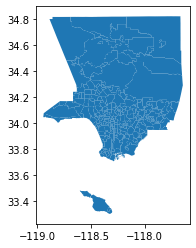

In [129]:
# Load the shape file from github
!wget -Nq https://raw.githubusercontent.com/kaushiktandon/COVID-19-Vaccine-Allocation/master/shape/la_shape.zip
!unzip -nq la_shape.zip -d shape
neighborhood_shapes = gpd.read_file("shape/la_shape.shp") # L.A. County neighborhoods shapefile
neighborhood_shapes.plot()

from shapely.geometry import Point, Polygon
neighborhood_shapes = neighborhood_shapes[['name','geometry']]
polys = neighborhood_shapes['geometry']

# Associate each census block group with a neighborhood

In [130]:
cbg_to_coordinates['Neighborhood'] = ''
for idx, row in tqdm(cbg_to_coordinates.iterrows(), total=cbg_to_coordinates.shape[0]):
  mask = polys.contains(Point(row['Longitude'], row['Latitude']))
  # This census block group belongs to this particular neighborhood
  neighborhood_row = neighborhood_shapes[mask]
  if (len(neighborhood_row) == 0):
    print(row)
  else:
    cbg_to_coordinates.at[idx, 'Neighborhood'] = neighborhood_row.iloc[0]['name']

cbg_to_coordinates.head()


Census Block Group    6037124700
Latitude                 34.1625
Longitude               -118.414
Neighborhood                    
Name: 58, dtype: object



,Census Block Group,Latitude,Longitude,Neighborhood
0,6037104404,34.263921,-118.428691,Pacoima
1,6037139302,34.176702,-118.538365,Tarzana
2,6037137502,34.163679,-118.596991,Woodland Hills
3,6037128910,34.160867,-118.459091,Sherman Oaks
4,6037132300,34.197459,-118.527311,Reseda


# Aggregate incoming/outgoing visits

In [131]:
import json

def aggregate(monthly_patterns_raw, month):

  safegraph_aggregated_neighborhoods_for_month = pd.DataFrame(neighborhood_shapes['name'])
  safegraph_aggregated_neighborhoods_for_month['month'] = month
  safegraph_aggregated_neighborhoods_for_month['Number of incoming visits'] = 0
  safegraph_aggregated_neighborhoods_for_month['Number of outgoing visits (no regI to regI)'] = 0
  safegraph_aggregated_neighborhoods_for_month['Number of outgoing visits (with regI to regI)'] = 0
  for region in safegraph_aggregated_neighborhoods_for_month['name']:
    key = 'to ' + str(region)
    safegraph_aggregated_neighborhoods_for_month[key] = 0

  count = 0
  for idx, row in tqdm(monthly_patterns_raw.iterrows(), total=monthly_patterns_raw.shape[0]):
    mask = polys.contains(Point(row['Longitude'], row['Latitude']))
    # This point of interest belongs to this particular neighborhood
    neighborhood_row = neighborhood_shapes[mask]
    if (len(neighborhood_row) == 0):
      count += 1
    else:
      poi_neighborhood = neighborhood_row.iloc[0]['name']
      previous_value = safegraph_aggregated_neighborhoods_for_month.loc[neighborhood_row.index, 'Number of incoming visits'].iloc[0]
      safegraph_aggregated_neighborhoods_for_month.at[neighborhood_row.index, 'Number of incoming visits'] = previous_value + row['raw_visitor_counts']

      visitors = json.loads(row['visitor_home_cbgs'])
      for visitor_cbg, visitor_count in visitors.items():
        visitor_cbg = int(int(visitor_cbg) / 10)
        intersection = cbg_to_coordinates[cbg_to_coordinates['Census Block Group'] == visitor_cbg]
        if (len(intersection) > 0):
          visitor_neighborhood = intersection.iloc[0]['Neighborhood']
          if visitor_neighborhood == '' or poi_neighborhood == '': continue
          previous_df = safegraph_aggregated_neighborhoods_for_month[safegraph_aggregated_neighborhoods_for_month['name'] == visitor_neighborhood].iloc[0]
          if poi_neighborhood != visitor_neighborhood:
            # Add to total outgoing visits if not from same neighborhood
            safegraph_aggregated_neighborhoods_for_month.at[previous_df.name, 'Number of outgoing visits (no regI to regI)'] = previous_df['Number of outgoing visits (no regI to regI)'] + visitor_count
          # Add to total outgoing visits if from same region
          safegraph_aggregated_neighborhoods_for_month.at[previous_df.name, 'Number of outgoing visits (with regI to regI)'] = previous_df['Number of outgoing visits (with regI to regI)'] + visitor_count
          # Add to individual outgoing visits regardless
          visiting_to = 'to ' + str(poi_neighborhood)
          safegraph_aggregated_neighborhoods_for_month.at[previous_df.name, visiting_to] = previous_df[visiting_to] + visitor_count

  print("Unknown neighborhood count: ", count)
  return safegraph_aggregated_neighborhoods_for_month

In [132]:
safegraph_aggregated_neighborhoods = pd.DataFrame()
for idx, month_path in enumerate(patterns_paths):
  monthly_patterns_raw = pd.read_csv(month_path)
  print("Aggregating for month: ", idx + 3)
  safegraph_aggregated_neighborhoods_for_month = aggregate(monthly_patterns_raw, idx+3)
  safegraph_aggregated_neighborhoods = pd.concat([safegraph_aggregated_neighborhoods, safegraph_aggregated_neighborhoods_for_month])
  print("Finished for month: ", idx + 3)

nei = safegraph_aggregated_neighborhoods.loc[(safegraph_aggregated_neighborhoods['Number of incoming visits'] != 0) | (safegraph_aggregated_neighborhoods['Number of outgoing visits (with regI to regI)'] != 0)]
nei

Aggregating for month:  3



Unknown neighborhood count:  592
Finished for month:  3
Aggregating for month:  4



Unknown neighborhood count:  571
Finished for month:  4
Aggregating for month:  5



Unknown neighborhood count:  560
Finished for month:  5
Aggregating for month:  6



Unknown neighborhood count:  592
Finished for month:  6
Aggregating for month:  7



Unknown neighborhood count:  636
Finished for month:  7
Aggregating for month:  8



Unknown neighborhood count:  585
Finished for month:  8
Aggregating for month:  9



Unknown neighborhood count:  598
Finished for month:  9


,name,month,Number of incoming visits,Number of outgoing visits (no regI to regI),Number of outgoing visits (with regI to regI),to Acton,to Adams-Normandie,to Agoura Hills,to Agua Dulce,to Alhambra,to Alondra Park,to Altadena,to Angeles Crest,to Arcadia,to Arleta,to Arlington Heights,to Artesia,to Athens,to Atwater Village,to Avalon,to Avocado Heights,to Azusa,to Baldwin Hills/Crenshaw,to Baldwin Park,to Bel-Air,to Bellflower,to Bell Gardens,to Bell,to Beverly Crest,to Beverly Grove,to Beverly Hills,to Beverlywood,to Boyle Heights,to Bradbury,to Brentwood,to Broadway-Manchester,to Burbank,to Calabasas,to Canoga Park,to Carson,...,to University Park,to Valinda,to Valley Glen,to Valley Village,to Val Verde,to Van Nuys,to Venice,to Vermont Knolls,to Vermont-Slauson,to Vermont Square,to Vermont Vista,to Vernon,to Veterans Administration,to View Park-Windsor Hills,to Vincent,to Walnut,to Walnut Park,to Watts,to West Adams,to West Carson,to Westchester,to West Compton,to West Covina,to West Hills,to West Hollywood,to Westlake,to Westlake Village,to West Los Angeles,to Westmont,to West Puente Valley,to West San Dimas,to West Whittier-Los Nietos,to Westwood,to Whittier,to Whittier Narrows,to Willowbrook,to Wilmington,to Windsor Square,to Winnetka,to Woodland Hills
2,Agoura Hills,3,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,Arleta,3,396,16377,16407,0,0,0,0,0,0,0,0,0,30,0,0,0,12,0,0,0,0,0,0,0,0,0,10,12,0,0,0,0,0,0,0,0,259,0,...,0,0,479,48,0,1591,0,4,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,79,0,0,0,0,0,0,0,0,0,0,0,0,0,0,113,237
10,Arlington Heights,3,80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,Atwater Village,3,18134,1334,2116,0,0,0,0,0,0,0,0,0,0,0,0,0,782,0,0,0,8,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,4,0,...,0,0,31,4,0,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,8,8
17,Baldwin Hills/Crenshaw,3,316,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,Westlake,9,1232,450,494,0,0,0,0,0,0,0,0,0,0,0,0,0,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,13,0,44,0,0,0,0,0,0,0,0,0,0,0,0,0,4
264,Westwood,9,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
268,Wilmington,9,96,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
270,Winnetka,9,23347,30633,35251,0,0,8,0,0,0,0,0,0,8,0,0,0,15,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,4,0,4,4,6698,0,...,0,0,230,32,0,1068,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2958,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4618,2921


In [133]:
nei.to_csv('safegraph_aggregated.csv', encoding='utf-8', index=False)